In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đọc dữ liệu
data = pd.read_csv('../datas/data_total_nam.csv')

In [2]:
import sys
sys.path.append('../extraction')  

from extraction import (
    create_training_data,
    calculate_accelerometer_features,
    calculate_accelerometer_fft_features,
    create_training_data_NN_like_micro
)

x_list, y_list, z_list, train_labels = create_training_data(
    data=data, window_size=10, step_size=5)


In [3]:
print("📌 Các nhãn xuất hiện:", set(train_labels))


📌 Các nhãn xuất hiện: {np.int64(0), np.int64(1)}


In [4]:
features = calculate_accelerometer_features(
    x_list=x_list, y_list=y_list, z_list=z_list, window_size=10)
# test


features = features[['avg_result_accl', 'y_energy',"y_min","y_mean","z_min","z_max"]]

# Kiểm tra có bao nhiêu giá trị NaN
print("🔍 Số NaN trong mỗi cột:")
print(features.isna().sum().sort_values(ascending=False).head(10))

features = features.fillna(features.mean())

c:\Users\ADMIN\OneDrive\Máy tính\Master_2024\new_sleep_posture_2025\nam_hay_k_nam\../extraction\extraction.py:102: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['x_skewness'] = [stats.skew(x) for x in x_list]
c:\Users\ADMIN\OneDrive\Máy tính\Master_2024\new_sleep_posture_2025\nam_hay_k_nam\../extraction\extraction.py:103: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['y_skewness'] = [stats.skew(y) for y in y_list]
c:\Users\ADMIN\OneDrive\Máy tính\Master_2024\new_sleep_posture_2025\nam_hay_k_nam\../extraction\extraction.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['z_skewness'] = 

🔍 Số NaN trong mỗi cột:
avg_result_accl    0
y_energy           0
y_min              0
y_mean             0
z_min              0
z_max              0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

(
    features_train, features_test,
    label_train, label_test
) = train_test_split(
    features, train_labels,
    test_size=0.25,
    random_state=42,
    shuffle=True
)


 Training Random Forest (optimized)...

 Random Forest Evaluation Results
 Training Accuracy: 1.0000
 Validation Accuracy: 1.0000
 Test Accuracy: 1.0000

--- Validation Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       335

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594


--- Test Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00       588

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



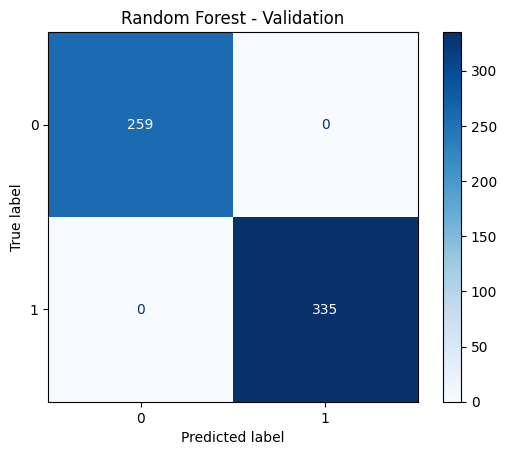

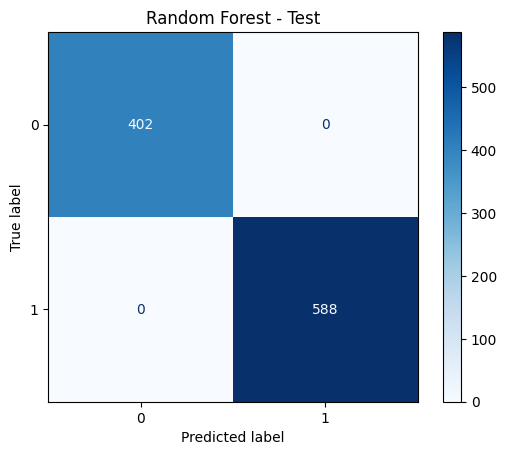

In [6]:

from models import train_RF
modelRF = train_RF(features_train, features_test, label_train, label_test)


 Training Logistic Regression (optimized)...

 Logistic Regression Evaluation Results
 Training Accuracy: 0.9979
 Validation Accuracy: 1.0000
 Test Accuracy: 0.9980

--- Validation Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       335

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594


--- Test Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00       588

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


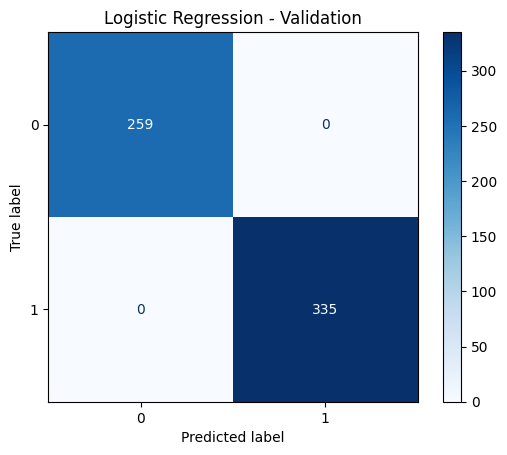

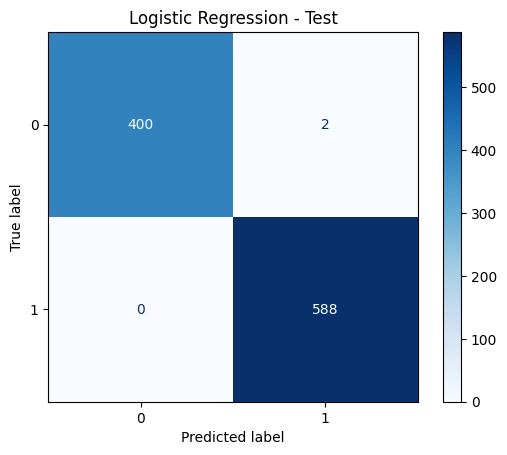

In [7]:
from models import train_LR
modelLR, scalerLr = train_LR(features_train, features_test, label_train, label_test)

In [9]:
import joblib
import os
def get_model_size_kb(model, scaler, name):
    """Lưu model & (nếu có) scaler, tính dung lượng và số tham số"""
    model_path = f"{name}_model.pkl"
    joblib.dump(model, model_path)
    model_kb = os.path.getsize(model_path) / 1024

    total_kb = model_kb
    scaler_kb = 0

    # 🔹 Lưu scaler nếu có
    if scaler is not None:
        scaler_path = f"{name}_scaler.pkl"
        joblib.dump(scaler, scaler_path)
        scaler_kb = os.path.getsize(scaler_path) / 1024
        total_kb += scaler_kb

    # 🔹 In kích thước
    print(f"📦 {name}: Model = {model_kb:.2f} KB | Scaler = {scaler_kb:.2f} KB | Total = {total_kb:.2f} KB")

    # 🔹 Nếu là mô hình tuyến tính (LR, SVM)
    if hasattr(model, "coef_"):
        n_params = np.prod(model.coef_.shape) + len(model.intercept_)
        print(f"🔢  → Số tham số huấn luyện: {n_params}")

    # 🔹 Nếu là mô hình cây (RF, GB)
    elif hasattr(model, "estimators_"):
        try:
            n_nodes = 0
            for est in model.estimators_:
                # GradientBoosting có thể là mảng 2D các cây con
                if isinstance(est, (list, np.ndarray)):
                    for sub_est in est:
                        if hasattr(sub_est, "tree_"):
                            n_nodes += sub_est.tree_.node_count
                else:
                    if hasattr(est, "tree_"):
                        n_nodes += est.tree_.node_count
            print(f"🌲  → Tổng số nút trong mô hình cây: {n_nodes}")
        except Exception as e:
            print(f"⚠️  Không thể đếm số nút (lý do: {e})")

    print("-" * 70)
    return total_kb

get_model_size_kb(modelRF, None, "RandomForest")
get_model_size_kb(modelLR, scalerLr, "LogisticRegression")

📦 RandomForest: Model = 43.40 KB | Scaler = 0.00 KB | Total = 43.40 KB
🌲  → Tổng số nút trong mô hình cây: 434
----------------------------------------------------------------------
📦 LogisticRegression: Model = 0.89 KB | Scaler = 1.05 KB | Total = 1.94 KB
🔢  → Số tham số huấn luyện: 7
----------------------------------------------------------------------


1.943359375